In [32]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import gensim
import plotly.graph_objects as go
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load dataset**

In [34]:
# Load train data
train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "latin1")

# Load test data
test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "latin1")

# Merge train and test data
dataset = pd.concat([train, test])

**Convert text labels to integer labels**

In [35]:
i = 0
for res in set(dataset["Sentiment"].values):
  dataset['Sentiment'][dataset['Sentiment'] == res] = i
  i = i + 1

**Pre-Processing**

In [36]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet of Train set
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : remove_url(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : remove_emoji(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : decontraction(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : char(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : x.lower())

**Split dataset**

In [45]:
X = dataset['OriginalTweet']
y = dataset['Sentiment']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=0)

num_label_train_index, num_label_train_values = np.unique(y_train, return_counts=True)
num_label_test_index, num_label_test_values = np.unique(y_test, return_counts=True)

i = 0
for res in set(dataset["Sentiment"].values):
  if(num_label_train_index[i] == i):
    num_label_train_index[i] = res
  if(num_label_test_index[i] == i):
    num_label_test_index[i] = res
  i = i + 1

print(num_label_train_index)

0
1
2
3
4
[0 1 2 3 4]


**Plot distribution of the classes in train set and test set**

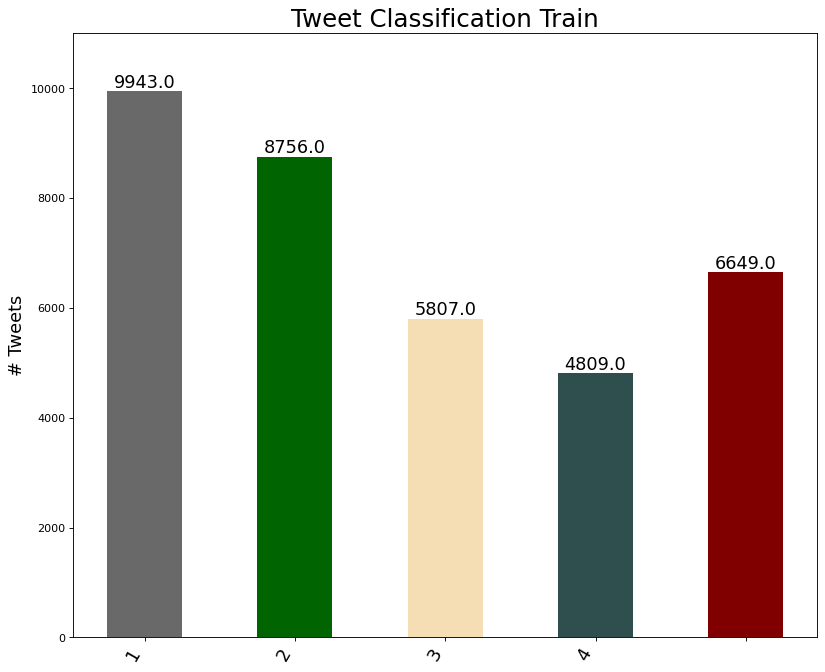

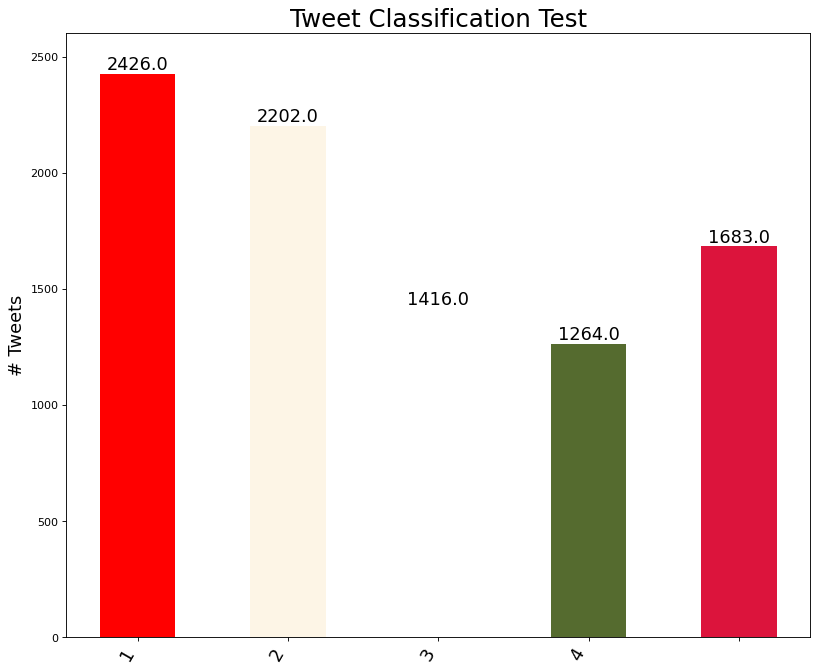

In [43]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train_index, num_label_train_values, "Tweet Classification Train", 11000)
plot_class_dist(num_label_test_index, num_label_test_values, "Tweet Classification Test", 2600)

**Plot number of words in the tweets**

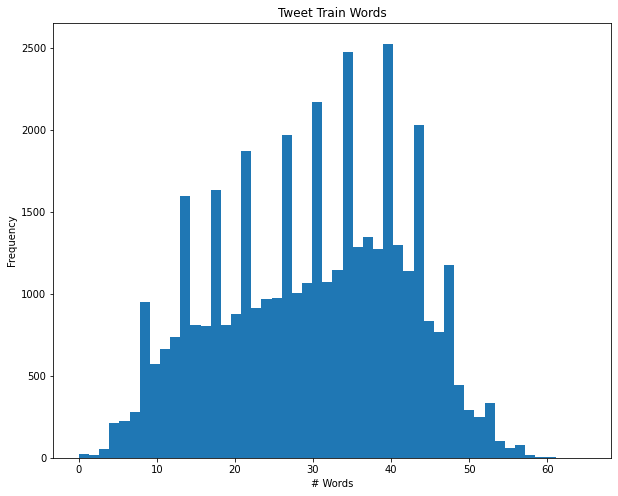

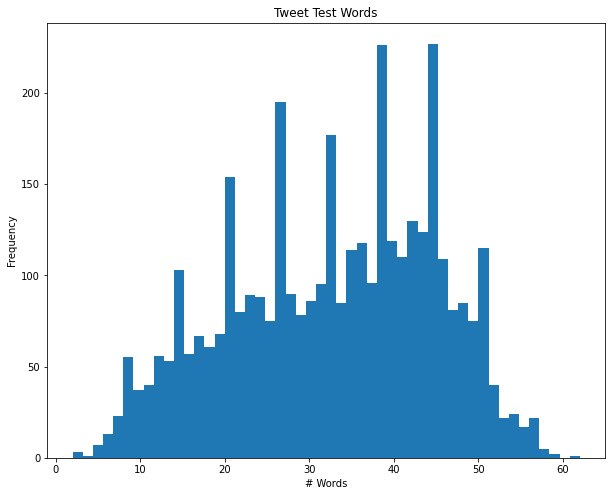

In [8]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()

test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()

**Upload pre-trained Word2Vec model**

In [9]:
wv_from_bin = models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/DLA_dataset/GoogleNews-vectors-negative300.bin', binary=True)

In [21]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split(' ')
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split(' ')

wv_from_bin = models.Word2Vec(sentences=list(train["TotalWords"]))

In [27]:
import gensim.downloader
wv_from_bin = gensim.downloader.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


**Create Vocabulary**

In [10]:
vectorizer = TfidfVectorizer(min_df=20).fit(train['OriginalTweet'].values)
x_train = vectorizer.transform(train['OriginalTweet'].values)
x_test = vectorizer.transform(test['OriginalTweet'].values)

In [11]:
def sent_vectorizer(sent, model):
  sent_vec = []
  numw = 0
  for w in sent:
    try:
      if numw == 0:
        sent_vec = model[w]
      else:
        sent_vec = np.add(sent_vec, model[w])
      numw+=1
    except:
      pass
  
  return np.asarray(sent_vec)/numw

In [12]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split(' ')
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split(' ')

In [28]:
x_train = []
for sentence in list(train['TotalWords']):
    x_train.append(sent_vectorizer(sentence, wv_from_bin))

x_test = []
for sentence in list(test['TotalWords']):
    x_test.append(sent_vectorizer(sentence, wv_from_bin))

In [29]:
x_train = pad_sequences(np.array(x_train), maxlen=300)
x_test = pad_sequences(np.array(x_test), maxlen=300)

**Baseline**

In [24]:
train["Sentiment"] = train["Sentiment"].astype('int')
test["Sentiment"] = test["Sentiment"].astype('int')

In [30]:
classifier = MLPClassifier(alpha = 0.7, max_iter=400) 
classifier.fit(x_train, list(train["Sentiment"]))
 
df_results = pd.DataFrame(data=np.zeros(shape=(1,3)), columns = ['classifier', 'train_score', 'test_score'] )
train_score = classifier.score(x_train, list(train["Sentiment"]))
test_score = classifier.score(x_test, list(test["Sentiment"]))
 
print(classifier.predict_proba(x_test))
print(classifier.predict(x_test))
 
df_results.loc[1,'classifier'] = "MLP"
df_results.loc[1,'train_score'] = train_score
df_results.loc[1,'test_score'] = test_score
print(df_results)

[[0.26205226 0.2343288  0.09522864 0.1081254  0.3002649 ]
 [0.29218378 0.23256152 0.19179753 0.14150245 0.14195473]
 [0.29218378 0.23256152 0.19179753 0.14150245 0.14195473]
 ...
 [0.29218378 0.23256152 0.19179753 0.14150245 0.14195473]
 [0.25229353 0.22709311 0.07909584 0.09853739 0.34298013]
 [0.29218378 0.23256152 0.19179753 0.14150245 0.14195473]]
[4 0 0 ... 0 4 0]
  classifier  train_score  test_score
0          0     0.000000    0.000000
1        MLP     0.289963    0.255661


In [ ]:
gnb = MultinomialNB()
print(type(np.array(x_train)))
y_pred = gnb.fit(x_train, train["Sentiment"]).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"] != y_pred).sum()))

<class 'numpy.ndarray'>
Number of mislabeled points out of a total 3798 points : 2851


In [31]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(x_train, train["Sentiment"])
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"] != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

Number of mislabeled points out of a total 3798 points : 2827


0.25566087414428645

In [ ]:
clf = SVC(kernel='linear', max_iter=100, decision_function_shape='ovo')
scores = cross_val_score(clf, x_train.toarray(), train["Sentiment"].values, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

'''
clf.fit(x_train.toarray(), train["Sentiment"].values)
y_pred = clf.predict(x_test.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)
'''

0.35 accuracy with a standard deviation of 0.01


'\nclf.fit(x_train.toarray(), train["Sentiment"].values)\ny_pred = clf.predict(x_test.toarray())\nprint("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))\nclf.predict_proba(x_test).shape\nclf.score(x_test, test["Sentiment"].values)\n'

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators=250)
clf.fit(x_train.toarray(), train["Sentiment"].values)
y_pred = clf.predict(x_test.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test.toarray()).shape
clf.score(x_test.toarray(), test["Sentiment"].values)

Number of mislabeled points out of a total 3798 points : 2015


0.4694576092680358

**New Network**

In [18]:
X = train['OriginalTweet']
y = train['Sentiment']

# Split data into train , test
X_train , X_val , y_train , y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_test = test['OriginalTweet']
y_test = test['Sentiment']

# Convert y to categorical 
y_train = to_categorical(y_train, 5)
y_test  = to_categorical(y_test, 5)
y_val  = to_categorical(y_val, 5)

max_features = 20000
tokenizer = Tokenizer(nb_words=300) # num_words=max_features, 
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

# convert tokenized texts into same padding size
maxlen = 300
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val_final = pad_sequences(list_tokenized_val, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

45774


In [19]:
embeddings_index = {}
for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
  coefs = np.asarray(vector, dtype='float32')
  embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

Found 3000000 word vectors.


In [20]:
model=Sequential()

#embedding layer
model.add(Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=False)) 

#lstm layer
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(64, return_sequences=True, dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(32,activation='relu')) 
model.add(Dense(5,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#Print summary of model
print(model.summary())

history = model.fit(X_train_final, y_train, epochs=5, validation_data=(X_val_final, y_val))

_,test_acc = model.evaluate(X_test_final, y_test)
print(test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          13732200  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 14,003,501
Trainable params: 271,301
Non-trainable params: 13,732,200
______________________________________